kaggle dataset link = https://www.kaggle.com/c/new-york-city-taxi-fare-prediction
# we are using sample data set bcz original is very large
# Fare amount is a dependent feature

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/taxifare.csv')

In [3]:
df.head
df.shape


(120000, 8)

feature engineering with respect to datetime

In [4]:
import datetime
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])-datetime.timedelta(hours=4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


In [6]:
df['Year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute


In [7]:
df.shape

(120000, 13)

In [8]:
import numpy as np 
df['mornight'] = np.where(df['hour']<12,0,1)

In [9]:
df.drop(['pickup_datetime'],axis=1,inplace=True)

we use manhat and euclidean distance but whenever we have longitude and longitude it is better to use haversine dis


In [10]:
##we create a function 
def haversine(df):
    '''calculate the great circle distance b/w two points on the earth (specified in decimal degrees)'''
    lat1 = np.radians(df['pickup_latitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    ##based on the formula x1 = dropoff_latitude x2 = dropoff_longitude
    dlat = np.radians(df['dropoff_latitude']-df['pickup_latitude'])
    dlong = np.radians(df['dropoff_longitude']- df['pickup_longitude'])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 #radius of earth in kilometeres. use 3956 for miles
    return c*r

In [11]:
df['Total_distance'] = haversine(df)

In [12]:
df.head

<bound method NDFrame.head of         fare_amount  fare_class  pickup_longitude  pickup_latitude  \
0               6.5           0        -73.992365        40.730521   
1               6.9           0        -73.990078        40.740558   
2              10.1           1        -73.994149        40.751118   
3               8.9           0        -73.990485        40.756422   
4              19.7           1        -73.990976        40.734202   
...             ...         ...               ...              ...   
119995         15.3           1        -73.955857        40.784590   
119996         15.3           1        -73.996329        40.772727   
119997         12.5           1        -73.988574        40.749772   
119998          4.9           0        -74.004449        40.724529   
119999          5.3           0        -73.955415        40.771920   

        dropoff_longitude  dropoff_latitude  passenger_count  Year  month  \
0              -73.975499         40.744746         

In [13]:
df = df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis =1)

In [14]:
df.head

<bound method NDFrame.head of         fare_amount  fare_class  passenger_count  Year  month  day  hour  \
0               6.5           0                1  2010      4   19     4   
1               6.9           0                1  2010      4   17    11   
2              10.1           1                2  2010      4   17     7   
3               8.9           0                1  2010      4   11    17   
4              19.7           1                1  2010      4   16    22   
...             ...         ...              ...   ...    ...  ...   ...   
119995         15.3           1                1  2010      4   18    10   
119996         15.3           1                1  2010      4   23     6   
119997         12.5           1                3  2010      4   18    14   
119998          4.9           0                1  2010      4   13     4   
119999          5.3           0                3  2010      4   17    12   

        minute  mornight  Total_distance  
0           17

#MONGO-DB operations 

In [15]:
import json
records = json.loads(df.T.to_json()).values() # T = transpose

In [16]:
import pymongo
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client['newyorktaxi']
col = db['rides']

In [17]:
col.insert_many(records)

Regression Model

In [18]:
X = df.iloc[:,1:]
y =  df.iloc[:,0]

Feature importance



In [20]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

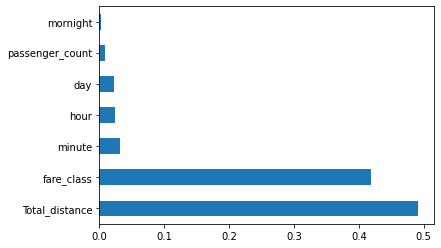

In [21]:
feat_importnaces = pd.Series(model.feature_importances_, index = X.columns)
feat_importnaces.nlargest(7).plot(kind='barh')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [24]:
import xgboost

In [25]:
regressor = xgboost.XGBRFRegressor()
regressor.fit(X_train,y_train)


XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=100,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [26]:
y_pred = regressor.predict(X_test)

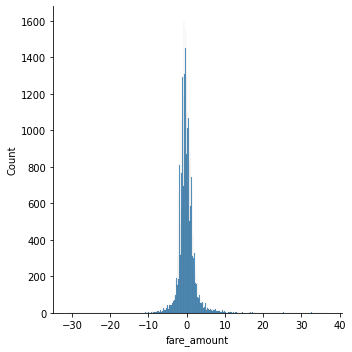

In [27]:
import seaborn as sns
sns.displot(y_test-y_pred)


In [28]:
from sklearn import metrics
print('mse', metrics.mean_squared_error(y_test,y_pred))
print('r2', metrics.r2_score(y_test,y_pred))
print('mae', metrics.mean_absolute_error(y_test,y_pred))
print('rmse',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

mse 6.673631331218544
r2 0.8833401061741302
mae 1.4400647541803784
rmse 2.5833372468995495


hyper parameter tuning



In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
n_estimators = [int(x) for x in np.linspace(start= 100, stop=1200, num = 12)]
learning_rate = ['0.05','0.1','0.2','0.3','0.5','0.6']
max_depth = [int(x) for x in np.linspace(start= 5,stop=30, num=6)]
subsample = [0.7,0.8,0.9]
min_child_weight = [3,4,5,6,7]

In [ ]:
random_grid = {
    'n_estimators' = n_estimators,
    'learning_rate' = learning_rate,
    'max_depth' = max_depth,
    'subsample'= subsample,
    'min_child_weight'= min_child_weight
}